#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [1]:
import pandas as pd

import numpy as np

import os

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

Подгрузим данные

In [2]:
pth = '/datasets/taxi.csv'
if os.path.exists(pth):
    data = pd.read_csv(pth,index_col=[0],parse_dates=[0])
data = data.sort_index(ascending=True)
print(data.index.is_monotonic)

NameError: name 'data' is not defined

Значит, хронологический порядок соблюден.

In [3]:
data = data.resample('1H').sum()
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

In [4]:
print(data.info())
print(data['num_orders'].unique())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None
[124  85  71  66  43   6  12  15  34  69  64  96  30  32  48  44  73  45
  61 113  58  90 120  75  20  11   7  46  54  91  36  59  82  83  89  49
  93 101 119  72 163 108  25   9  17  56  52  57  28  41  76  68  63  60
  26  42  27  22  39  19  51  80  77  86 176  16   3  14  31  50  62  37
  40  47  10  81 100 121  24  38  55  99 127  94 143  78  65  97 114  88
  79  84  29   1   4  70 117   5  18  53 102  33 107 118 153 105  67  35
 109  21   8 123 110 134 133 137 126  13  74  95 139  87 106  92 148 182
 104 131  98   2 112 103 128 166 111  23   0 129 164 165 138 142 159 115
 130 135 150 167 147 253 140 172 116 125 162 201 136 146 154 145 155 158
 156 193 197 234 157 122 144 149

In [5]:
print(data.isna().sum())
print(data.duplicated().sum())

num_orders    0
dtype: int64
4165


In [6]:
display(data[data.duplicated()])

,num_orders
datetime,
2018-03-01 15:00:00,66
2018-03-01 16:00:00,43
2018-03-01 21:00:00,66
2018-03-02 03:00:00,64
2018-03-02 06:00:00,11
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [7]:
print(data.index.duplicated().sum())

0


Данные корректны.

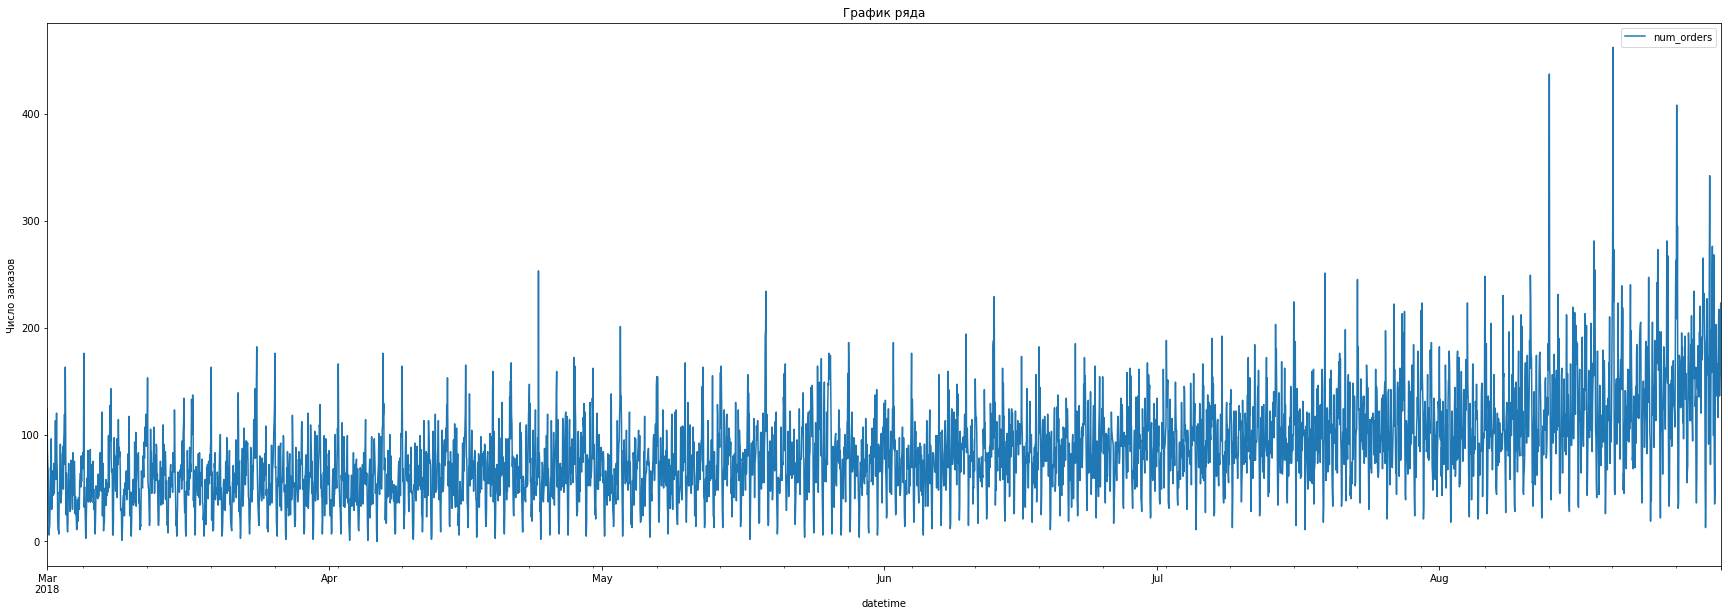

In [8]:
plt.figure(figsize=(30,10))
plt.title('График ряда')
plt.ylabel('Число заказов')
plt.xlabel('Время')
data.plot(ax=plt.gca());

Как мы можем заметить, ряд растет с течением времени.

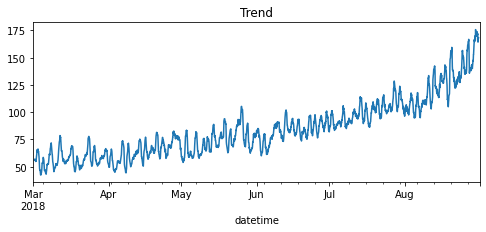

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8,10))
plt.subplot(311)
plt.title('Trend')
decomposed.trend.plot(ax=plt.gca());


Мы можем сделать вывод, что ряд растет с течением времени.Период сезонности - дневная.

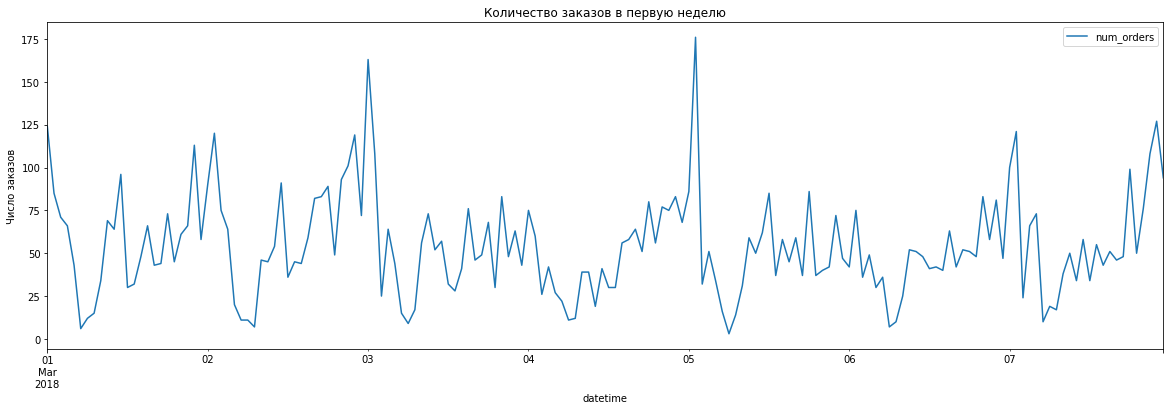

In [10]:
plt.figure(figsize=(20,6))
plt.title('Количество заказов в первую неделю')
plt.ylabel('Число заказов')
plt.xlabel('Время')
data[:168].plot(ax=plt.gca())
plt.show()


1) Пики наблюдаются в середине дня, на это время ,видимо, приходится наибольшее число полетов. А также ночью(пик с 22 до 2).Спады наблюдаются утром и ближе к вечеру.Может это связано с тем что такси становится дорогим из-за пробок( т к на это время приходится час пик).Поэтому такси не выгодно брать клиентам.
    2)Сезонность обусловлена работой и отдыхом людей.Многие прилетают в другие города в середине недели по работе.Другие улетают 


 1) Пики наблюдаются в середине недели, а также на выходных.Спады наблюдаются в начале недел и середине.
 2)Сезонность обусловлена работой и отдыхом людей.Многие прилетают в другие города в середине недели по работе.Другие улетают и возвращаются на выходных.Поэтому так много заказов на такси.

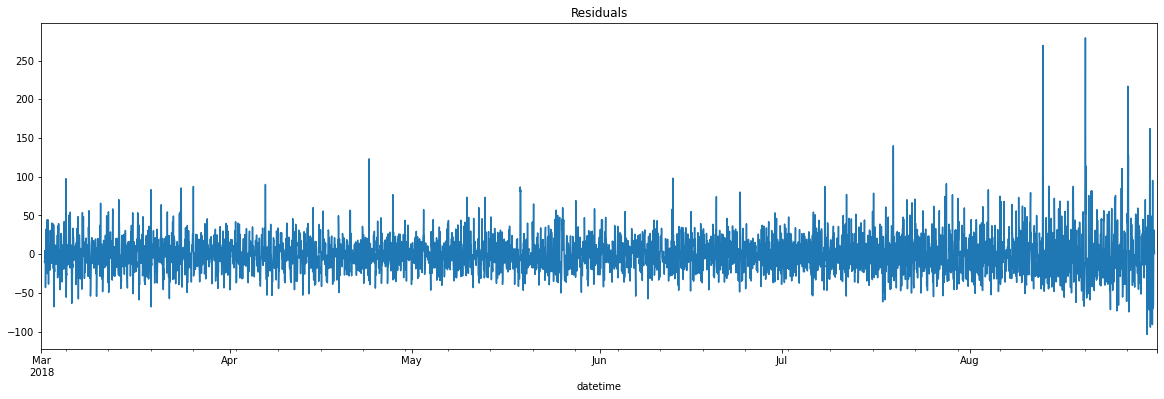

In [11]:
plt.figure(figsize=(20,6))
plt.title('Residuals')
decomposed.resid.plot(ax=plt.gca())
plt.show()

<div class="alert alert-info">
<h2> Комментарий студента: v.2<a class="tocSkip"></h2>
<b>  Как мы можем заметить, остатки показывают сильный разброс.А значит ряд нестационарный.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Нет вывода про остатки - в первом комментарии по этому вопросу был опорный план для ответа на вопрос про остатки.

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
Тут корректно!
</div>

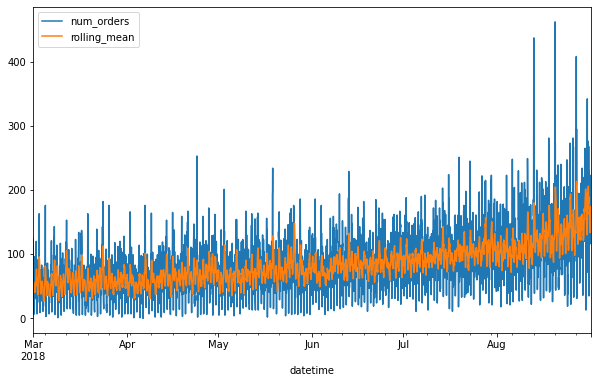

In [12]:
df = data
df['rolling_mean'] = df.rolling(10).mean()
plt.figure(figsize=(10,6))
df.plot(ax=plt.gca())
plt.show()

<div class="alert alert-info">
<h2> Комментарий студента: v.3<a class="tocSkip"></h2>
<b> Как мы можем заметить скользящее среднее растет со временем. Таким образом, наш ряд нестационарен.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
По этому графику также нет вывода - стоит сделать вывод о стационарности ряда в зависимости от характера сглаженного среднего на графике.

</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Не учтено: стоит добавить вывод по этому графику. На случай, если с ним есть сложности, подскажу, что стоит анализировать направленность скользяшей средней: если она не изменяется с течением времени, то ряд стационарен, если изменяется - ряд нестационарен. Сделай, пожалуйста, вывод о скользящем среднем выше.

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [13]:
result = adfuller(data['num_orders'], autolag='AIC')
print('ADF',result[0])
print('p-value',result[1])
print('1%', result[4]['1%'])
print('5%',result[4]['5%'])
print('Нулевая гипотеза - ряд стационарный')
if result[0] < result[4]['5%']:
    print('Нулевая гипотеза отвергнута - ряд не стационарный')
else:
    print('Нулевая гипотеза не отвергнута - ряд стационарный')

ADF -3.0689242890279558
p-value 0.028940051402612906
1% -3.431842162413052
5% -2.8621993540813637
Нулевая гипотеза - ряд стационарный
Нулевая гипотеза отвергнута - ряд не стационарный


<div class="alert alert-info">
<h2> Комментарий студента:<a class="tocSkip"></h2>
<b>  Таким образом, наш ряд не стационарный.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Окей, тест провели, вывод получили правильный - тут хорошо!
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Посмотрели на уникальные значения целевого признака, а также вывели общую информацию о таблице - окей!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Аналитическая часть проекта вышла довольно скромной - её следует расширить. Хороший анализ временного ряда должен состоять из двух компонентов: EDA данных и анализ временного ряда.
    
EDA должен включать:
1. Анали пропусков - метод `isna()` и `.sum()` после него для подсчёта.
2. Анализ явных дубликатов - метод `.duplicated()` и `.sum()` для подсчёта. Однако во временном ряду может быть ситуация, когда количество заказов может быть одинаковым - это не всегда аномалия. Если дубликаты будут - на них стоит посмотреть в таблице, чтобы проверить наверняка - поможет фильтрация вида `df[df.duplicated()]`.
3. Анализ неявных дубликатов - метод `.duplicated()`, но применённый уже к индексу: если одинаковое количество заказов в разные дни может быть одинаковым, то двух одинаковых дат быть не должно.
    
Анализ временного ряда должен включать:
1. Визуализацию исходного ряда - стоит сделать вывод хотя бы об общей тенденции: ряд растёт с течением времени или остаётся стабильным?
2. Ряд нужно разложить на компоненты (тренд, сезонность, остатки) и проанализировать:
    
2.1. Какой вывод можем сделать по итогу анализа трендовой компннены ряда? Есть рост с течением времени или нет?

2.2. Сезонную компоненту для лушчего понимания природы сезонности стоит исследовать на более коротком промежутке времени - подойдёт 3-7 суток. Для выполнения этого пункта стоит найти ответы на следующие вопросы:

- какова природа сезонности (часовая, суточная, дневная, недельная, месячная)?;
    
- в какие периоды (с учётом пункта выше) наблюдаются пики заказов, а в какие - спады?;
    
- чем обсуловлена природа сезонности? (важно помнить, что у нас данные про заказы такси в аэропортах - как это соотносится с пунктом выше).

2.3. Что видим на графике остатков? Тут можно сделать предположение о стационарности ряда: если остатки ведут себя стабильно и не показывают сильный разброс, можем сделать предположение о стационарности ряда, и наоборот - нестационарный ряд будет показывать на графике разброс.

3. Стоит оценить стационарность ряда и сделать об этом вывод. Сделать это можно с помощью сглаживания скользящим средним и последующей визуализацией сглаженного ряда на графике (отлично будет смотреться на графике исходного временного ряда как его дополнение из п.2.1) - это самый простой способ. В реальных же задачах с временными рядами, в особенности - с финансовыми данными или биржевыми котировками, график не всегда поможет достоверно оценить стационарность ряда. Поэтому для оценки стационарности ряда лучше использовать тест Дики — Фуллера (подробнее о нём можно глянуть тут: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html, а вот тут можно глянуть пример реализации: https://www.helenkapatsa.ru/tiest-diki-fulliera/) - он даст наиболее точный результат. Рекомендую попробовать оба способа - важно понимать, как соотносятся результаты двух способов. Также тест Дики-Фулллера стоит провести на нескольких уровнях значимости - 1% и 5%. Вдруг результаты будут отличаться?
    
При создании графиков, пожалуйста, придерживайся основных правил создания визуализаций:
    
1. Стоит подписать названия осей X и Y.
2. Также стоит дать название графику.
3. Технические комментарии типа `<AxesSubplot:xlabel='datetime'>` стоит убирать: это можно сделать, поставив точку с запятой в последней строке кода в блоке визуализации, либо сделать последней строкой кода этого блока метод `plt.show()`.
4. Стоит оптимизировать график по размеру: не стоит делать графики слишком маленькими, но и перебарщивать с размером, чтобы график в ячейке приходилось скроллить, тоже не стоит. Дефолтный размер графика почти всегда не самый оптимальный, поэтому его стоит оптимизировать всегда:)

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено всё, кроме сезонности и остатков.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
К сезонности и остаткам стоит вернуться.

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит делать промежуточные выводы о проделанной работе, это довольно полезная практика, которая имеет большую ценность для получателя отчёта.
        
Достаточно будет двух-трёх тезисных предложений об основных шагах и полученных выводах.
        
</div>

<div class="alert alert-info">
<h2> Комментарий студента:<a class="tocSkip"></h2>
<b>  Наш ряд увеличивается со временем. Ряд обладает дневной сезонностью(в4 дня). Ряд не стационарный.Можем переходить к обучению.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

## Обучение

In [14]:
def make_features(data,max_lag,rolling_mean_size):
    df = data.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1,max_lag+1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Написали функцию для создания новых признаков - отлично!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
Организация работы функции таким образом, чтобы она работала с глобальной переменной - не самая хорошая практика: если что-то пойдёт не так, придётся заново запускать весь процесс предобработки данных. 
        
Лучше организовывать функцию так, чтобы она принимала на вход набор данных и возвращала результат работы, чтобы его можно было сохранить в новой переменной. Концепт:
        
    def foo(df):
        df.dropna(inplace=True)
    
    foo(df)
        
В этом случае изменения необратимы, так как мы модифицировали глобальную переменную `df` - эту переменную придётся загружать в память заново и заново её обрабатывать.
        

    def foo(df):
        return df.dropna()
    
    foo(df)
        
        
Изменения будут необратимы и в таком случае, даже несмотря на на наличие `return`: несмотря на то, что работаем мы с локальной переменной, функция всё равно работает с объектом в памяти, связанным с глобальной переменной, пусть и через алиас.
        
    def foo(df):
        df_foo = df.copy()
        return df_foo.dropna()
    
    df_new = foo(df)
        
Здесь внутри функции исходный объект копируется, и работа уже происходит с новым объектом. В этом случае результат работы функции с исходными данными мы складываем в новую переменную - таким образом исходная глобальная переменная не подвергается вмешательству и сохранятся на случай, если функция сработала неправильно.
        
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Концептуально выделение признака "год" из даты - хорошая идея, но конкретно в нашем наборе данных у нас нет наблюдений в какой-то иной год, кроме 2018. Таким образом, мы просто создали константный признак, не приносящий ценности для модели, но расширяющий признаковое пространство. Стоит его удалить:)
        
То же касается признака "месяц": так как у нас данные только за неполный год и так как данные отстортированы по возрастанию даты, модель сможет работать адекватно только с теми значениями месяца, которые были на обучающей выборке. В оперативных данных таких значений месяца не будет, и модель не сможет работать с ними корректно.
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [15]:
df_new = make_features(df,24,24)
df_new = df_new.drop('rolling_mean',axis=1)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Здесь довольно важный момент: после исправления функции `make_features` она возвращает результат своей работы, поэтому его нужно сохранить в какую-то переменную. В твоём случае ты просто использовал функцию без сохранения результата, поэтому она просто вернула тебе временное представление с результатом работы, но никуда его не сохранила. Чтобы всё работало, нужно присвоить результат работы функции какой-то переменной. Вроде, `df_new = make_features(df,24,24)`.
    
Также нужно удалить из таблицы столбец `rolling_mean`, который у тебя появился после анализа скользящих средних.
        </div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Не учтено.
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Создали новые признаки - отлично!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Давай немного порассуждаем о размере окна для скольящего среднего: ты передаёшь значение для окна в 1 шаг, соответственно, твоё скользящее среднее будет смотреть в прошлое на 1 час назад (так как ранее мы сделали часовое ресэмплирование). Тут есть как плюсы, так и минусы: если взять размер окна слишком маленьким, то модель будет быстрее схватывать новые тренды в данных, но не будет иметь достаточно истричности для формирования самого тренда, то есть получит хорошую уточняющую способность от оперативных данных, но уточнять особо будет нечего. С другой стороны, если задать слишком широкое окно для скользящего среднего, мы получим модель, хорошо помнящую, что было раньше, но довольно неповоротливую с точки зрения улавливания оперативных изменения - все вновь поступающие сигналы будут глушиться тяжёлым хвостом из прошлого. Оптимальность окна - это тоже своего рода гиперпараметр, который стоит подбирать экспериментально. В нашем случае есть суточная сезонность, поэтому значение `24` было бы оптимальным, а вот `1` - слишком мало, такой признак будет бесполезен.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Значение `100` для величины лага великовато - учитывая, что сезонность имеет суточный характер и что данные собраны на уровне часа, значения `24` было бы достаточно: при 100 лаговых переменных мы сильно увеличиваем время обучения моделей, а результат вряд ли будет стоить такой заминки.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [16]:
train, test = train_test_split(df_new,shuffle=False,test_size=0.1)
train = train.dropna()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Сплитование сделано корректно как с точки зрения учёта специфики временного ряда (отключено перемешивание), так и размера тестовой выборки.
</div>

In [17]:
x_train = train.drop('num_orders',axis=1)
y_train = train['num_orders']
x_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Выделили признаки для обучения и целевой признак - хорошо!
</div>

In [18]:
tss = TimeSeriesSplit(n_splits=3)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
В таком виде использование `TimeSeriesSplit` некорректно: в цикле ты просто перебираешь индексы, переприсваивая названия переменных. В итоге вмето обучения три раза модель обучается только один раз, и смысл кросс-валидации теряется. 
    
При использовании твоего подхода модель нужно обучать внутри цикла. Или альтернативный способ, более простой - передать `tss` параметру `cv` при использовании `cross_val_score` или `GridSearchCV`.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [19]:
scoring = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Круто, что решил использовать `make_scorer`!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Вместо того, чтобы каждый раз извлекать квадратный корень из ответа, ты можешь в `make_scorer` передать `squared=False`, и на выходе мы получим `RMSE` без лишних усилий.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
При использовании `make_scorer` для задач регрессии важно указать параметр `greater_is_better=False`, так как по умолчанию `GridSearchCV` стремится максимизировать оптимизируемую метрику, а в случае задачи регрессии метрика тем лучше, чем ниже.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [20]:
grid = [{'n_estimators' : [100,200,50],'max_depth':range(2,9)}]
forest = RandomForestRegressor(random_state=12345)
model = GridSearchCV(forest,grid,scoring=scoring,cv=tss,verbose=1)
model.fit(x_train,y_train)
print('RMSE:', model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
RMSE: -28.115221008663905
{'max_depth': 8, 'n_estimators': 200}


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Тут довольно грубая ошибка - для задачи регрессии ты используешь алгоритм классификации - это неверное решение. Используй, пожалуйста, алгоритм для регресионных задач.
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Тут ты немного намешал кашу из двух подходов к кросс-валидации:
1. Одновременно использовать `GridSearchCV` и `cross_val_score` не нужно: если подбираем гиперпараметры - используем `GridSearchCV`, если нет - `cross_val_score`.
2. Оценку на кросс-валидации при использовании `GridSearch` нужно получить из атрибута `best_score_` после обучения инструмента, в случае `cross_val_score` нужно взять среднее значение массива, а не выводить весь массив.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Также важные замечания по параметрам:
1. `max_depth` перебирается в диапазоне от 1 до 20 - это избыточно широкая сетка, так как после значения глубины в 5-7 деревья начинают сильно переобучаться. С другой стороны, чем глубже дерево, тем дольше оно обучается. Поэтому рекомендую исследовать диапазон от 3 до 7-9.
2. `n_estimators` исследуются в таком же диапазоне - для случайного леса это очень маленький диапазон. Сила случайного леса в большом количестве эстиматоров в ансамбле: по умолчанию используется 100 эстиматоров, поэтому при исследовании диапазона оптимальных значений этого параметра рекомендую отталкиваться от 100 с шагом в 50/100.
3. В случае `RandomForestRegressor` также важно задать параметр случайности `random_state` (только подбирать его не нужно).
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
С `max_depth` теперь всё хорошо, но вот с `n_estimators` есть вопросы: ты рассматриваешь последовательность от 100 до 150 с шагом в 200 - это физически невозможно: шаг больше самой последовательности. Скорректируй, пожалуйста, сетку параметров.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [21]:
model = LinearRegression()
scores = cross_val_score(model,x_train,y_train,cv=tss,scoring = scoring)
print('RMSE:',scores.mean() )

RMSE: -27.73737408354424


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Ты повторил первую ошибку с кросс-валидацией - перечитай, пожалуйста, первый комментарий об особенности кросс-валидации для временных рядом и использовании `TimeSeriesSplit`: то, что ты в ячейке `19` создал `train` и `test` выборки с помощью `TimeSeriesSplit`, не исключает ошибочной кросс-валидации с перемешиванием при использовании `cv=5`. Вернись, пожалуйста, к первому комментарию по этому вопросу.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
С линейной регрессией окей!
</div>

Наиболее подходящая модель - Линейная регрессия.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Есть несколько замечаний по этому разделу:
1. Проведение промежуточной валидации на независимой выборке - хорошее решение, однако оно не очень помогает в решении проблемы недо- или переобучения. Для того, чтобы этот эффект минимизировать, проводят кросс-валидацию. В случае подбора гиперпараметров можно использовать `GridSerachCV` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или `RandomizedSearchCV` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) - это инструменты для подбора оптимальных гиперпараметров, которые при подборе провдят кросс-валидацию. Результаты кросс-валидации доступны в атрибует `best_score_` после завершения обучения инструмента. В случае, если подбор параметров не осуществляется, кросс-валидацию можно провести с помощью `cross_val_score` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). В случае этого инструмента результаты кросс-валидации будут в массиве, который этот инструмент возвращает (длина массива зависит от количества фолдов). Чтобы вывести итоговую метрику, нужно посчитать среднее значение элементов этого массива. 
2. Для случайного леса стоит сделать подбор гиперпараметров модели с помощью `GridSerachCV` или `RandomizedSearchCV`. Оптимизировать стоит не менее двух параметров.
    
При проведении кросс-валидации стоит учитывать специфику временных рядов: правильным решением будет использование специального инструмента библиотеки `sklearn` для кросс-валидации временных рядов `TimeSeriesSplit` (подробнее тут: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). Он формирует фолды так, чтобы в фолдах для обучения не было данных из фолдов для тестирования, что критически важно при работе с временными рядами. Экземпляр этого валидатора нужно будет передать в параметр `cv` при использовании `GridSearchCV` или `RandomizedSearchCV`.
    
Также рекомендую почитать статью о сплитовании для временных рядов - даст понимание, как работает `TimeSeriesSplit`: https://medium.com/@Hong_Tang/timeseries-split-with-sklearn-tips-8162c83612b9. 
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Тут учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит сделать промежуточные выводы о проделанной работе в блоке.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Тут учтено!
</div>

In [22]:
model = DummyRegressor(strategy='mean')
model.fit(x_train,y_train)
predictions = model.predict(x_test)
print('RMSE:', mean_squared_error(predictions,y_test,squared=False))

RMSE: 84.6499381993622


<div class="alert alert-info">
<h2> Комментарий студента:<a class="tocSkip"></h2>
<b>  Мы разбили временные ряды для обучения.Написали 3 алгоритма для решения задачи регрессии, из которых наилучший результат показала Линейная Регрессия.Проверим ее на тестовой выборке.

## Тестирование

In [23]:
model = LinearRegression()
model.fit(x_train,y_train)
predictions = model.predict(x_test)
print('RMSE: ',mean_squared_error(y_test,predictions,squared=False))

RMSE:  44.98181783101926


<div class="alert alert-info">
<h2> Комментарий студента:\Вывод V.3<a class="tocSkip"></h2>
<b> Сначала мы подготовили данные.Затем провели анализ. Тренд показал нам,что ряд растет со временем, нашли сезонность.Подготовили данные к обучению, учитывая специфику временных рядов.Обучили несколько алгоритмов регрессии.Наилучшие результаты получились для Линейной Регрессии.Проверили модель на тестовой выборке.Метрика качества удовлетворяет условию.Модель прошла проверку.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Вывод - огонь!
</div>

<div class="alert alert-info">
<h2> Комментарий студента:<a class="tocSkip"></h2>
<b>  Таким образом, наша модель прошла проверку метрикой качества.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Кажется, всё же не прошла: значение метрики выше 48. Думаю, после учёта оставленных комментариев порог всё же будет взят:)
</div>

<div class="alert alert-info">
<h2> Комментарий студента: v.2<a class="tocSkip"></h2>
<b>  Вроде бы все исправил.Модель все равно не проходит проверку.Подскажите,что делать, пожалуйста.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Оставил тебе комментарии по этому поводу в блоке с функцией `make_features`. Так как ты не сохранил результат её работы, то твоя модель учится только на одной переменной - скользящее среднее.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

In [24]:
y_test = pd.Series(y_test)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
А зачем тут цикл, если можно сделать `y_test=pd.Series(y_test)`?
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Тут учтено!
</div>

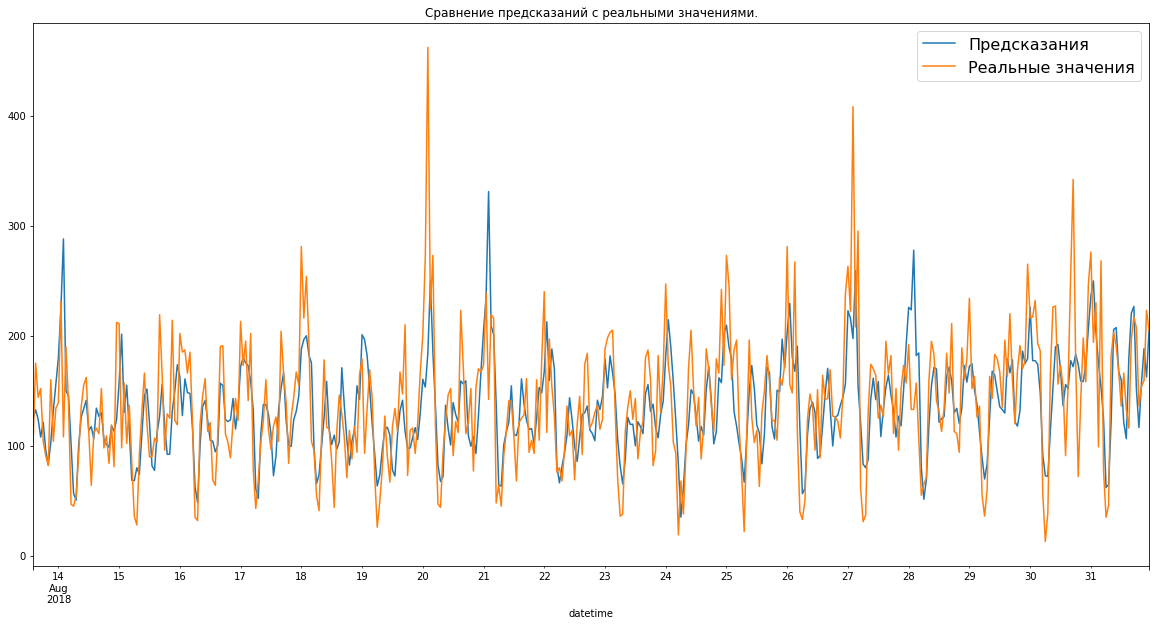

In [25]:
predictions = pd.Series(predictions,index = y_test.index)
plt.figure(figsize=(20,10))
predictions.plot(ax=plt.gca(),label = 'Предсказания')
y_test.plot(label = 'Реальные значения')
plt.legend(fontsize=16)
plt.title('Сравнение предсказаний с реальными значениями.')
plt.show()

Таким образом, модель прошла проверку с RMSE меньшим 48.Она нам подходит.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Хороший результат!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Лучшую модель стоит проверить на адекватность - для этого стоит сделать модель, предсказывающую среднее значение ряда на тренировочной выборке, оценить её качество на тестовой выборке и сравнить с качеством нашей модели - вдруг результат у константной модели, всегда предсказывающей одно и то же число, будет сопоставим или даже лучше нашей модели? Тогда стоило бы что-то поменять в процессе построения модели.
    
В качестве константной модели рекомендую использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html).
        </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь также было бы очень полезно визуализировать предсказания твоей лучшей модели и сравнить их с правильными ответами в формате линейного графика - так мы сможем более наглядно понять, в каких местах твоя модель делает хорошие предсказания, а в каких ошибается.

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
График построен!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Однако по оси X стоит отложить дату, так как мы сравниваем 2 ряда - реальный и предсказанный - на одном и том же промежутке.
    
Добавить даты можно при создании объекта `pd.Series` через обращение к индексу, скажем, `x_test`:
    
    pred = pd.Series(pred, index=x_test.index)
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
То, что нужно!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит сделать промежуточные выводы о проделанной работе в блоке.

<div class="alert alert-info">
<h2> Комментарий студента:<a class="tocSkip"></h2>
<b> Мы проверили модель на тестовой выборке.Значение метрики не больше 48, значит, алгоритм нам подходит.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Есть вывод!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Но нужно будет переделать - пока метрика не соответствует границе проекта.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Всё ещё нужна корректировка вывода.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Учтено!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
По завершении проекта стоит сделать итоговый вывод: в него можно включить основные шаги проекта, а также ключевые выводы, полученные в ходе работы над ним.
        </div>

<div class="alert alert-info">
<h2> Комментарий студента:\Вывод<a class="tocSkip"></h2>
<b> Сначала мы подготовили данные.Затем провели анализ. Тренд показал нам,что ряд растет со временем, нашли сезонность в 4 дня.Подготовили данные к обучению, учитывая специфику временных рядов.Обучили несколько алгоритмов регрессии.Наилучшие результаты получились для Линейной Регрессии.Проверили модель на тестовой выборке.Метрика качества удовлетворяет условию.Модель прошла проверку.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Итоговый вывод также появился - отлично!
</div>

<div class="alert alert-info">
<h2> Комментарий студента:<a class="tocSkip"></h2>
<b>  Спасибо большое за ваши подсказки и полезные ссылки.Постарался выполнить, как можно больше исправлений.Было интересно.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Всегда пожалуйста - рад, что тебе было интересно:)
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Тебе удалось задать классный старт работы над проектом - хорошо поработал, молодец! На следующих итерациях займёмся причёсыванием твоего проекта и доведением его точки наивысшего качества:)
    
Отмечу несколько плюсов твоей работы.

Ты верно выполнил все задания проекта, последовательно прошёл все его шаги, получил верные выводы и ничего не упустил в процессе - это классно, ты молодец!
    
Понравилось также, что ты не ограничился использованием простеньких алгоритмов типа линейной регрессии, а использовал более продвинутые инструменты вроде случайного леса.
    
Есть некоторые рекомендации по улучшению твоего проекта, касающиеся как оформления, так и аналитической части и части работы с моделями - я оставил их в комментариях жёлтого цвета. Будет здорово, если ты учтёшь эти рекомендации во время следующей итерации работы над проектом - тогда ценность твоего проекта сильно возрастёт.
    
Также в проекте есть критические замечания. Важно устранить эти замечания, чтобы проект был принят. К ним я оставил комментарии красного цвета, в которых описаны необходимые для устранения замечаний действия.  
    
Если по тому, что нужно сделать, будут вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью:)
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.2.

Шарухан, спасибо, что прислал проект на повторное ревью: часть замечаний была учтена, проект стал лучше!
    
Однако ещё есть над чем поработать - актуальные замечания указаны в комментариях с меткой `v.2`. 
    
Жду тебя снова:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.3.

Шарухан, спасибо, что снова прислал проект - часть вопросов закрыли, отлично постарался!
    
Продолжаем работу над проектом - актуальные комментарии в ячейках с подписью `v.3`.
    
Жду тебя снова:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.4.

Шарухан, теперь по проекту нет вопросов - работа принята!
    
Спасибо за качественную работу над проектом, желаю успехов в дальнейшем обучении:)